In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies

In [2]:
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist
# from pyro.poutine import trace, replay, block
# from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
# from pyro.infer import SVI, Trace_ELBO, Predictive

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import get_name
from pyciemss.ODE.interventions import time_and_state_dependent_intervention_builder
# import sys
# sys.path.append("../")

#
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

/Users/zuck016/.pyenv/versions/jz-scenario2-eval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plotting Utilities

In [3]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected ')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_total_obs"]
    #infection_total = sum([prediction[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])

    I_low = torch.quantile(prediction["I_total_obs"], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction["I_total_obs"], 0.95, dim=0).detach().numpy()

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, observation='I_total_obs'):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    #infection_total = sum([data[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])
    ax.plot(tspan, data[observation].squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

# Setup Parameters

![SIDARTHE](../img/SIDARTHE.png)

In [4]:
full_tspan = get_tspan(1, 100, 1000)

num_samples = 500

# Total population, N.
N = 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, D0, A0, R0, T0, H0, E0 = 200./60e6, 20./60e6, 1./60e6, 2./60e6, 0, 0, 0

# Everyone else, S0, is susceptible to infection initially.

S0 = N - I0 - D0 - A0 - R0 - T0 - H0 - E0


#I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))

# Probabilistic Forecasting - Passing unit test 1
There are two ‘unit tests’ we want to pass, to ensure that we understood and can reproduce the published model:

## 1.a Unit Test \#1:

Set the initial values and parameters, as described in the Supplementary Methods section of the publication (pg. 9 of the pdf): 

### 1.a.1 Initial Values: 
* $I = 200/60e6$,
* $D = 20/60e6$, 
* $A = 1/60e6$, 
* $R = 2/60e6$, 
* $T = 0$, 
* $H = 0$, 
* $E = 0$; 
* $S = 1 – I – D – A – R – T – H – E$. 

Let total population = 60e6.


### 1.a.2 Parameters: 

$$\alpha = 0.570, \beta = \delta  = 0.011, \gamma = 0.456, \epsilon = 0.171, \theta = 0.371, \zeta = \eta = 0.125, \mu = 0.017, \nu = 0.027, \tau = 0.01, \lambda = \rho = 0.034$$ and $$\kappa = \xi = \sigma = 0.017$$.

### 1.a.3 Time of peak total infections

Simulate for 100 days, and determine the day and level of peak total infections (sum over all the infected states I, D, A, R, T). Expected output: The peak should occur around day 47, when ~60% of the population is infected.


In [5]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

# ode_model = SIDARTHE(N=1,
#                  alpha_prior=dist.Delta(torch.tensor (0.570)) ,
#                  beta_prior=dist.Delta(torch.tensor (0.011)) ,
#                  gamma_prior=dist.Delta(torch.tensor (0.456)) ,
#                  delta_prior=dist.Delta(torch.tensor (0.011)) ,
#                  epsilon_prior=dist.Delta(torch.tensor (0.171)) ,
#                  lamb_prior =dist.Delta(torch.tensor (0.034)) ,
#                  zeta_prior=dist.Delta(torch.tensor (0.125)) ,
#                  eta_prior=dist.Delta(torch.tensor (0.125)) ,
#                  kappa_prior=dist.Delta(torch.tensor (0.017)) ,
#                  theta_prior=dist.Delta(torch.tensor (0.371)) ,
#                  rho_prior=dist.Delta(torch.tensor (0.034)) ,
#                  xi_prior=dist.Delta(torch.tensor (0.017)) ,
#                  sigma_prior=dist.Delta(torch.tensor (0.017)) ,
#                  mu_prior=dist.Delta(torch.tensor (0.017)) ,
#                  nu_prior=dist.Delta(torch.tensor (0.027)) ,
#                  tau_prior=dist.Delta(torch.tensor (0.01)) )

In [6]:
from pyciemss.ODE.models import MIRA_SIDARTHE
from pathlib import Path
import os
MODELPATH = '../../test/models/evaluation_examples/scenario_2/'

SIDARTHEPATH = 'scenario2_sidarthe.json'
plotting_ode_model = MIRA_SIDARTHE.from_mira(os.path.join(MODELPATH,SIDARTHEPATH))
param2transition = {
    trans.rate.key: trans
    for trans in plotting_ode_model.G.transitions.values()
}
param2transition

{'beta': <mira.modeling.Transition at 0x13c32f5e0>,
 'gamma': <mira.modeling.Transition at 0x13c32e830>,
 'delta': <mira.modeling.Transition at 0x13c32e230>,
 'alpha': <mira.modeling.Transition at 0x13c32e410>,
 'epsilon': <mira.modeling.Transition at 0x13c32d8a0>,
 'zeta': <mira.modeling.Transition at 0x13c32c880>,
 'lambda': <mira.modeling.Transition at 0x13c32c430>,
 'eta': <mira.modeling.Transition at 0x13c32ebf0>,
 'rho': <mira.modeling.Transition at 0x13c32f1f0>,
 'theta': <mira.modeling.Transition at 0x13c32ded0>,
 'kappa': <mira.modeling.Transition at 0x13c32c190>,
 'mu': <mira.modeling.Transition at 0x13c32c040>,
 'nu': <mira.modeling.Transition at 0x13c32cd60>,
 'xi': <mira.modeling.Transition at 0x13c32d7b0>,
 'tau': <mira.modeling.Transition at 0x13c32eef0>,
 'sigma': <mira.modeling.Transition at 0x13c313160>}

In [7]:
plotting_ode_model.var_order

OrderedDict([('Ailing', <mira.modeling.Variable at 0x13c32d060>),
             ('Diagnosed', <mira.modeling.Variable at 0x13c32e110>),
             ('Extinct', <mira.modeling.Variable at 0x13c32ce50>),
             ('Healed', <mira.modeling.Variable at 0x13c32ca30>),
             ('Infected', <mira.modeling.Variable at 0x13c32f0d0>),
             ('Recognized', <mira.modeling.Variable at 0x13c32f820>),
             ('Susceptible', <mira.modeling.Variable at 0x13c32d090>),
             ('Threatened', <mira.modeling.Variable at 0x13c32c160>)])

In [8]:
initial_state = tuple(torch.as_tensor(v.data['initial_value'])
                      if v.data['initial_value'] is not None else torch.as_tensor(0.)
                      for v in plotting_ode_model.var_order.values())
initial_state

(tensor(1.6667e-08),
 tensor(3.3333e-07),
 tensor(0.),
 tensor(0.),
 tensor(3.3333e-06),
 tensor(3.3333e-08),
 tensor(1.0000),
 tensor(0.))

In [9]:
#prior_prediction = sample(plotting_ode_model, num_samples, initial_state, full_tspan)
single_prediction = sample(plotting_ode_model, 1, initial_state, full_tspan)

### Day of peak infection

Simulate for 100 days, and determine the day and level of peak total infections (sum over all the infected states I, D, A, R, T). Expected output: The peak should occur around day 47, when ~60% of the population is infected.


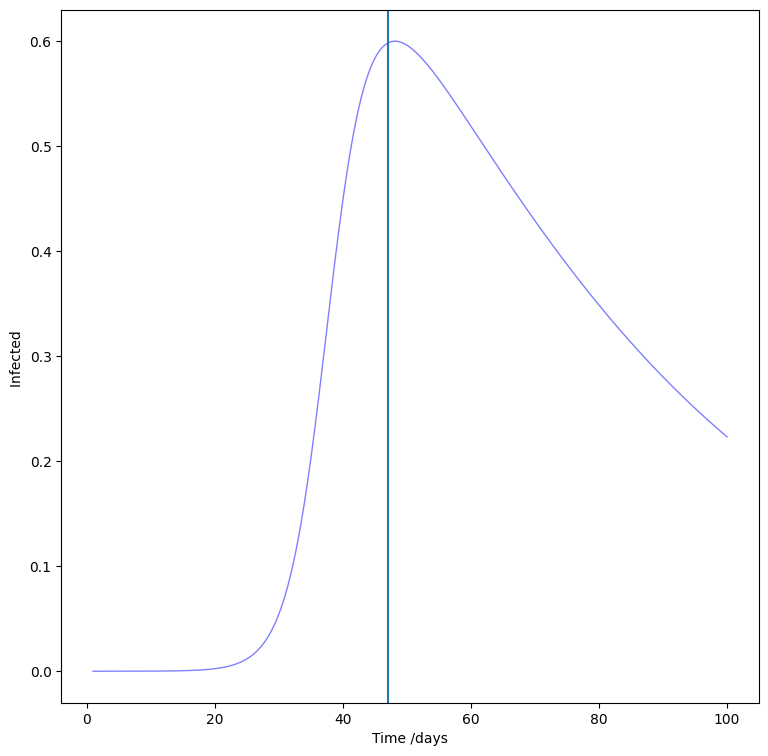

In [10]:
#single_prediction = sample(plotting_ode_model, 1, initial_state, full_tspan)
ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast",
                    observation='obs_total_infections')
#ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax.axvline(47)


## 1.b Unit Test \#2: 

Now update the parameters to reflect various interventions that Italy implemented during the first wave, as described in detail on pg. 9.  Simulate for 100 days, reproduce the trajectories in Fig. 2B, and determine the day and level of peak total infections (sum over all the infected states I, D, A, R, T). Expected output: Trajectories in Fig. 2B, peak occurs around day 50, with ~0.2% of the total population infected.

### Day 4 social distancing

After day 4, as a consequence of basic social-distancing measures due to the public being aware of the epidemic outbreak and due to recommendations (such  as washing hands often, not touching one’s face, avoiding handshakes and keeping  distance) and early measures (such as closing schools) by the Italian government,  we set $\alpha= 0.422, \beta = \delta = 0.0057$  and $\gamma = 0.285$, so the new basic reproduction number becomes $R_0 = 1.66$.



In [11]:
def SI_alpha_intervention(t, flux):
    alpha = 0.570
    if t < 4:
        return flux
    elif t < 22:
        return flux/alpha * 0.422
    elif t < 28:
        return flux/alpha* 0.360
    else:
        return flux/alpha*0.210
    
def SD_beta_intervention(t, flux):
    beta = 0.011
    if t < 4:
        return flux
    elif t < 22:
        return flux/beta * 0.0057
    else:
        return flux/beta* 0.005

def SA_gamma_intervention(t, flux):
    gamma = 0.456
    if t < 4:
        return flux
    elif t < 22:
        return flux/gamma * 0.285
    elif t < 28:
        return flux/gamma * 0.200
    else:
        return flux/gamma * 0.110

def SR_delta_intervention(t, flux):
    delta = 0.011
    if t < 4:
        return flux
    elif t < 22:
        return flux/delta* 0.0057
    else:
        return flux/delta* 0.0057



### Day 12 screening limited to symptomatic individuals
Also, after day 12, we set $\epsilon  = 0.143$ as a consequence of the policy limiting screening to symptomatic individuals only; thus, totally asymptomatic individuals  are almost no longer detected, while individuals with very mild symptoms are still  detected (hence $\epsilon$ is not set exactly to zero). Due to this, $R_0 = 1.80$. 

In [12]:
def ID_epsilon_intervention(t, flux):
    epsilon = 0.171
    if t < 12:
        return flux
    elif t < 38:
        return flux/epsilon * 0.143
    else:
        return flux/epsilon * 0.200
    

#plotting_ode_model = pyro.do(ode_model, {"noise_var": torch.tensor([0.000001])})

### Day 22 incomplete lockdown
![SIDARTHE](../img/SIDARTHE.png)

After day 22, the lockdown, at first incomplete, yields $\alpha  = 0.360,  \beta = \delta = 0.005$  and $\gamma = 0.200$;  also, $\zeta = \eta = 0.034, \mu = 0.008, \nu = 0.015, \lambda = 0.08$  and  $\rho= \kappa = \xi = \sigma = 0.017$. Hence, the new basic reproduction number becomes $R_0 = 1.60$.

![SIDARTHE-eqn.png](../img/SIDARTHE-eqn.png)


In [13]:

def IA_zeta_intervention(t, flux):
    zeta = 0.125
    if t < 22:
        return flux
    elif t < 38:
        return flux/zeta*0.034
    else:
        return flux/zeta*0.025
    
def DR_eta_intervention(t, flux):
    eta = 0.125
    if t < 22:
        return flux
    elif t < 38:
        return flux/eta * 0.034
    else: 
        return flux/eta*0.025
    
def AT_mu_intervention(t, flux):
    mu = 0.017
    if t < 22:
        return flux
    else:
        return flux/mu * 0.008
    
def RT_nu_intervention(t, flux):
    nu = 0.027
    if t < 22:
        return flux
    else:
        return flux/nu*0.015
    
def IH_lamb_intervention(t, flux):
    lamb = 0.034
    if t < 22:
        return flux
    else:
        return flux/lamb*0.08

def DH_rho_intervention(t, flux):
    rho = 0.034
    if t < 22:
        return flux
    elif t < 38:
        return flux/rho*0.017
    else:
        return flux/rho*0.020

 

### Day 28 fully operational lockdown
After day 28, the lockdown is fully operational and gets stricter (working is no longer a good reason for going out: gradually, non-indispensable activities are  stopped): we get $\alpha  = 0.210$ and $\gamma = 
0.110$,  hence $R_0 = 0.99$. 

### Day 38 wider testing campaign launched
After day 38, a wider testing campaign is launched: this yields $\epsilon  = 0.200$,  and also $\rho  = \kappa = \xi = 0.020$,  while $\sigma = 0.010$  and $\zeta = \eta = 0.025$.  Therefore, $R_0 = 0.85$.

In [14]:
def AH_kappa_intervention(t, flux):
    kappa = 0.017
    if t < 38:
        return flux
    else:
        return flux/kappa*0.020

def RH_xi_intervention(t, flux):
    xi = 0.017
    if t < 38:
        return flux
    else:
        return flux/xi*0.020
    
def TH_sigma_intervention(t, flux):
    sigma = 0.017
    if t < 38:
        return flux
    else:
        return flux/sigma*0.010


### Unit Test \#2: 
Now update the parameters to reflect various interventions that Italy implemented during the first wave, as described in detail on pg. 9.  Simulate for 100 days, reproduce the trajectories in Fig. 2B, and determine the day and level of peak total infections (sum over all the infected states I, D, A, R, T). Expected output: Trajectories in Fig. 2B, peak occurs around day 50, with ~0.2% of the total population infected.

![SIDARTHE.png](../img/SIDARTHE.png)

Reproduction number $\mathcal{R}_0$:
$$r_1  =  \epsilon + \zeta  +  \lambda$$ 
$$r_2  =  \eta  +  \rho$$  
$$r_3  =  \theta  +  \mu  +  \kappa$$  
$$r_4  =\nu +  \xi  +  \tau_1$$  
$$r_5  =\sigma +  \tau_2$$  

 $$\mathcal{R}_0 = \frac{\alpha  +  \frac{\beta\epsilon}{r_2} +  \frac{\gamma\zeta}{r_3} +  \delta\left(  \frac{\eta\epsilon}{r_2r_4}+  \frac{\zeta\theta}{r_3r_4}\right)}{r_1}$$


In [15]:

zeta = 'flux_' + get_name(param2transition['zeta'])
print(zeta + " %f" % (5.0000))

flux_trans_(('Infected', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833'), ('property', 'ncit:C113725')), ('Ailing', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C25269'), ('property', 'ncit:C113725')), 'NaturalConversion') 5.000000


In [16]:
interventions = {"alpha": SI_alpha_intervention,
                 "beta": SD_beta_intervention,
                 "gamma": SA_gamma_intervention,
                 "delta": SR_delta_intervention,
                 "epsilon": ID_epsilon_intervention,
                 "lambda": IH_lamb_intervention,
                 "zeta": IA_zeta_intervention,
                 "eta": DR_eta_intervention,
                 "kappa": AH_kappa_intervention,
                # "theta": AR_theta_intervention,
                 "rho": DH_rho_intervention,
                 "xi": RH_xi_intervention,
                 "sigma": TH_sigma_intervention,
                 "mu": AT_mu_intervention,
                 "nu": RT_nu_intervention}
parameter_intervention = {}
intervened_ode_model = plotting_ode_model

for param in interventions:
    parameter_intervention.update(time_and_state_dependent_intervention_builder(
        "flux_" + get_name(param2transition[param]),
         interventions[param], full_tspan))
    
intervened_ode_model = intervene(intervened_ode_model, parameter_intervention)

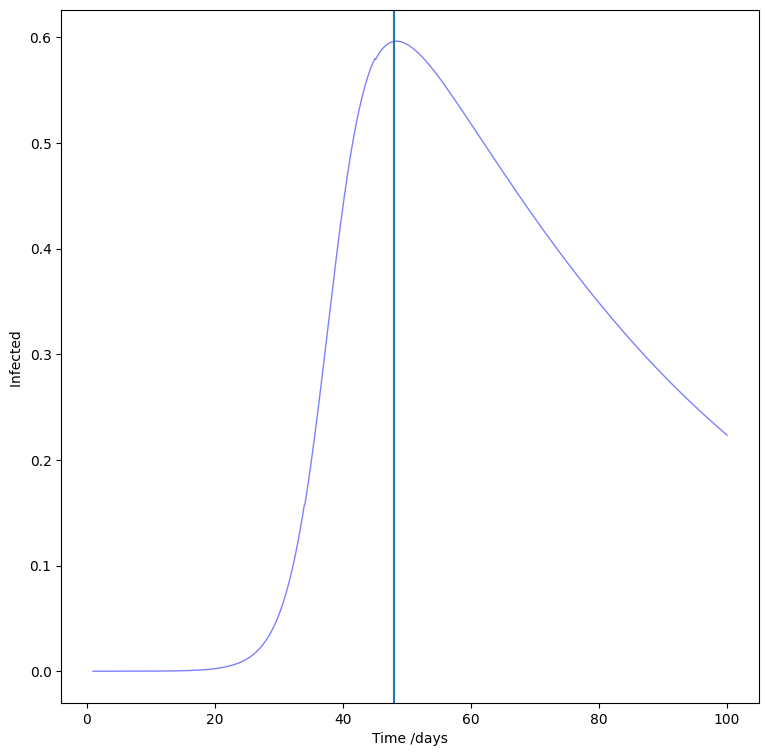

In [18]:
single_prediction = sample(intervened_ode_model, 1, initial_state, full_tspan)
ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast",
                    observation='obs_total_infections')
#ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax.axvline(48)


In [19]:
with pyro.poutine.trace() as tr:
    new_intervened_model(initial_state, full_tspan)
    
print(tr.trace.nodes.keys())


NameError: name 'new_intervened_model' is not defined

In [49]:
tr.trace.nodes[f"{zeta} 5.0"]

{'type': 'sample',
 'name': "flux_trans_(('Infected', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C3833'), ('property', 'ncit:C113725')), ('Ailing', ('identity', 'ido:0000511'), ('disease_status', 'ncit:C25269'), ('property', 'ncit:C113725')), 'NaturalConversion') 5.0",
 'fn': MaskedDistribution(),
 'is_observed': True,
 'args': (),
 'kwargs': {},
 'value': tensor(1.1530e-06),
 'infer': {'_deterministic': True},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (),
 'done': True,
 'stop': False,
 'continuation': None}

In [15]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

# ode_model = SIDARTHE(N=1,
#                  alpha_prior=dist.LogNormal(torch.log(torch.tensor (0.570)), torch.tensor(0.5)) ,
#                  beta_prior=dist.LogNormal(torch.log(torch.tensor (0.011)), torch.tensor(0.5)) ,
#                  gamma_prior=dist.LogNormal(torch.log(torch.tensor (0.456)), torch.tensor(0.5)) ,
#                  delta_prior=dist.LogNormal(torch.log(torch.tensor (0.011)), torch.tensor(0.5)) ,
#                  epsilon_prior=dist.LogNormal(torch.log(torch.tensor (0.171)), torch.tensor(0.5)) ,
#                  lamb_prior =dist.LogNormal(torch.log(torch.tensor (0.034)), torch.tensor(0.5)) ,
#                  zeta_prior=dist.LogNormal(torch.log(torch.tensor (0.125)), torch.tensor(0.5)) ,
#                  eta_prior=dist.LogNormal(torch.log(torch.tensor (0.125)), torch.tensor(0.5)) ,
#                  kappa_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
#                  theta_prior=dist.LogNormal(torch.log(torch.tensor (0.371)), torch.tensor(0.5)) ,
#                  rho_prior=dist.LogNormal(torch.log(torch.tensor (0.034)), torch.tensor(0.5)) ,
#                  xi_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
#                  sigma_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
#                  mu_prior=dist.LogNormal(torch.log(torch.tensor (0.017)), torch.tensor(0.5)) ,
#                  nu_prior=dist.LogNormal(torch.log(torch.tensor (0.027)), torch.tensor(0.5)) ,
#                  tau_prior=dist.LogNormal(torch.log(torch.tensor (0.01)), torch.tensor(0.5)) )

## 1.c Sensitivity analysis

## 1.d Policies that prevent infections from exceeding 1/3 of the population

Now return to the situation in b.i (constant parameters that don’t change over time). Let’s say we want to increase testing, diagnostics, and contact tracing efforts (implemented by increasing the detection parameters  and ). Assume that $\theta \ge 2\epsilon$ , because a symptomatic person is more likely to be tested. What minimum constant values do these parameters need to be over the course of a 100-day simulation, to ensure that the total infected population (sum over all the infected states I, D, A, R, T) never rises above 1/3 of the total population?




### Problem Formulation
* **Quantity of interest**:  Total infections out of $N=60,000,000$ population
$$I_{total}(t; \mathbf{u}, \mathbf{Z}) = I(t) + D(t) + A(t) + R(t) + T(t)$$

A conservative estimate for the quantity of interest is
$$M(u, Z) = \max_{1\leq t \leq 100} I_{total}(t; \mathbf{u}, \mathbf{Z})/N$$




* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Detection parameter for Infected ($\epsilon$) assuming that $\theta=2\epsilon$
    * Two detection parameters $\theta, \epsilon$, constraining $\theta \ge 2\epsilon$.
    


* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the magnitude of the parameter interventions.
    * Constraint - Risk of normalized total infections exceeding the prescribed threshold of $1/3$, $\mathcal{R}( M(\mathbf{u},\mathbf{Z}))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

#### Formulation 1: Optimize $\epsilon$ only, assuming $\epsilon = \theta$
\begin{equation} 
\begin{split} 
\epsilon^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon, \mathbf{Z}) \ge 1/3) \le 0.05
\end{split} 
\end{equation}

#### Formulation 2: Optimize $\epsilon$ and $\theta$ constraining $\theta \ge 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^\ast, \theta^\ast= \underset{\{\epsilon,\theta\}\in\mathcal{U}}{\arg\min}\ & \theta + \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon,\theta, \mathbf{Z}) \ge 1/3) \le 0.05, \\
& \theta \ge 2\epsilon
\end{split} 
\end{equation}

Apart from probability of exceedance, we will explore quantiles and superquantiles as risk measures.